# Resolução da folha de exercícios n.° 4 da matéria PTC-3569, "Introdução à Inteligência Computacional", ministrada pelo Prof. Dr. Ademar Ferreira
Aluna: Renata Leite Leandro, N.° USP: 11246993

## Introdução
Usaremos os seguintes pacotes para a resolução do exercício:

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import mpmath
import scipy.stats as stats

In [60]:
from random import random
from random import seed
from mpmath import *
from sklearn.metrics import mean_absolute_error

E, para uma boa visualização dos gráficos que serão plotados, usamos os seguintes comandos:

In [61]:
# Adiciona linhas no background dos gráficos, facilitando a visualização
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set(style="whitegrid", rc=custom_params)

# Objetivo geral do exercício

##### Neste exercício será utilizado o algoritmo Backpropagation para classificação de dados. Propõe-se que se faça um programa com uma camada escondida para classificar um determinado conjunto de dados, utilizando a função de ativação tanh. É necessário que se possa variar o número de nós da camada escondida, de modo a escolher o caso de melhor desempenho. Ademais, as entradas devem ser normalizadas para média nula e variância unitária, e o critério de parada utilizado será o gradiente do erro médio quadrático. Pede-se ainda que sejam feitas uma versão em batelada e outra em amostra por amostra.

## Resolução:

Vamos começar pela leitura e organização de nosso conjunto de dados, fornecido através de um simples arquivo .txt:

In [62]:
# Leitura dos dados enviados em arquivo .txt:
df_treino = pd.read_fwf('Anexo 1 da Lista 4 - treina.txt', names=['input1', 'input2', 'input3', 'input4', 'output'])
df_teste = pd.read_fwf('Anexo 2 da Lista 4 - teste.txt', names=['input1', 'input2', 'input3', 'input4'])

In [63]:
df_treino.head()

,input1,input2,input3,input4,output
0,6.7,3.3,5.7,2.1,3
1,5.1,3.8,1.5,0.3,1
2,7.2,3.2,6.0,1.8,3
3,6.2,2.8,4.8,1.8,3
4,5.0,3.4,1.6,0.4,1


In [64]:
df_teste.head()

,input1,input2,input3,input4
0,5.7,2.8,4.1,1.3
1,7.6,3.0,6.6,2.1
2,4.9,2.5,4.5,1.7
3,7.3,2.9,6.3,1.8
4,4.8,3.0,1.4,0.1


Como podemos observar, os dados já vieram divididos em conjunto de treino (output fornecido) e conjunto de teste (output não fornecido). Agora que já lemos nossos datasets, podemos prosseguir para a próxima etapa, que é a normalização das entradas, para que estas tenham média nula e variância unitária. Utilizaremos a normalização Z-score.

In [65]:
# Normalização Z-score para os dados de treino:
x1_treino_norm = stats.zscore(df_treino['input1'].to_numpy().tolist())
x2_treino_norm = stats.zscore(df_treino['input2'].to_numpy().tolist())
x3_treino_norm = stats.zscore(df_treino['input3'].to_numpy().tolist())
x4_treino_norm = stats.zscore(df_treino['input4'].to_numpy().tolist())
# Substituindo os inputs do dataset de treino para seus valores normalizados:
df_treino['input1'], df_treino['input2'], df_treino['input3'], df_treino['input4'] = x1_treino_norm, x2_treino_norm, x3_treino_norm, x4_treino_norm

# Normalização Z-score para os dados de teste:
x1_teste_norm = stats.zscore(df_teste['input1'].to_numpy().tolist())
x2_teste_norm = stats.zscore(df_teste['input2'].to_numpy().tolist())
x3_teste_norm = stats.zscore(df_teste['input3'].to_numpy().tolist())
x4_teste_norm = stats.zscore(df_teste['input4'].to_numpy().tolist())
# Substituindo os inputs do dataset de teste para seus valores normalizados:
df_teste['input1'], df_teste['input2'], df_teste['input3'], df_teste['input4'] = x1_teste_norm, x2_teste_norm, x3_teste_norm, x4_teste_norm

In [66]:
df_treino.head()

,input1,input2,input3,input4,output
0,0.979912,0.497987,1.097793,1.268183,3
1,-1.030164,1.535459,-1.280507,-1.188125,1
2,1.608061,0.290492,1.267672,0.858798,3
3,0.351763,-0.539486,0.588158,0.858798,3
4,-1.155793,0.705481,-1.223881,-1.051664,1


In [67]:
df_teste.head()

,input1,input2,input3,input4
0,-0.034577,-0.483579,0.230499,0.155503
1,2.100559,0.019343,1.652882,1.187778
2,-0.933582,-1.237963,0.458080,0.671641
3,1.763432,-0.232118,1.482196,0.800675
4,-1.045958,0.019343,-1.305675,-1.392910


Agora que os valores do nosso conjunto de dados seguem uma escala comum, iremos, por fim, dividir nosso dataset de treino em inputs e outputs e adequar o formato dos nossos dados para futuro uso nas funções:

In [68]:
# Separando o dataset de treino em inputs e outputs:
inputs_treino = df_treino.drop(columns=['output'])
outputs_treino = df_treino['output']

# Transformando as tabelas em listas:
l_inputs_teste = df_teste.to_numpy().tolist()
l_inputs_treino = inputs_treino.to_numpy().tolist()
l_outputs_treino = []
for output in df_treino['output']:
    l_outputs_treino.append([output])
    
# Transformando os valores esperados do output em +1, para quando o valor pertence à classe, e -1, para quando não pertence:
cont = 0
novo_l_outputs_treino = []
for output in l_outputs_treino:
    if output == [1]:
        novo_l_outputs_treino.append([+1, -1, -1])
    elif output == [2]:
        novo_l_outputs_treino.append([-1, +1, -1])
    elif output == [3]: 
        novo_l_outputs_treino.append([-1, -1, +1])
    cont += 1
l_outputs_treino = novo_l_outputs_treino

### Parte I: construindo as funções

Construiremos, então, nosso algoritmo de Backpropagation. Começaremos pelo pseudo-código e, em seguida, construiremos o algoritmo completo.

In [ ]:
#####PSEUDO-CÓDIGO#####


# Inicialização da network:
função cria_network(D, nh, c):
    Inicializa variável Wh como uma matriz de números aleatoriamente gerados entre -0.5 e 0.5
    Inicializa a variável Bh como uma matriz de números aleatoriamente gerados entre -0.5 e 0.5
    Inicializa variável Ws como uma matriz de números aleatoriamente gerados entre -0.35 e 0.35
    Inicializa variável Bs como uma matriz de números aleatoriamente gerados entre -0.35 e 0.35
    retorna Wh, Bh, Ws, Bs          
    
# Treinamento da network:
função treina_network(network, inputs, output_esperado, η, nmax):
    Cria a variável Wh
    Cria a variável Bh
    Cria a variável Ws
    Cria a variável Bs
    Cria a variável lista_epochs_n
    Cria a variável lista_theta_θ
    n = 0
    θ = 1
    while n != nmax:
        if θ > 0.01:
            ### FORWARD PROPAGATION
            Inicializa a variável ativacao_hidden_layer pelo cálculo w * input + bias
            Y = tanh de ativacao_hidden_layer
            Inicializa a variável ativacao_output_layer pelo cálculo w * input (output da camada oculta) + bias
            output_predito = tanh de ativacao_output_layer
            ### BACK PROPAGATION
            erro = output_esperado - output_predito
            Inicializa a variável θ como o erro médio quadrático da variável erro
            Inicializa a variável d_output_predito como a derivada da tangente hiperbólica do output de saída
            Inicializa a variável erro_hidden_layer, que calcula o erro da camada oculta através do erro da camada de saída
            Inicializa a variável d_hidden_layer como a derivada da tangente hiperbólica do output oculto
            ### ATUALIZANDO PESOS E BIAS E PASSANDO O LOOP DE EPOCHS
            Atualiza o valor da variável Ws
            Atualiza o valor da variável Bs
            Atualiza o valor da variável Wh
            Atualiza o valor da variável Bh
            Adiciona a epoch atual em lista_epochs_n
            Adiciona o θ atual em lista_theta_θ
            n += 1       
        else:
            n = nmax       
    retorna lista_epochs_n, lista_theta_θ, Wh, Bh, Ws, Bs, output_predito

# Predição dos outputs de uma network:
função predicao(inputs, Wh, Bh, Ws, Bs):
    ### FORWARD PROPAGATION
    Inicializa a variável ativacao_hidden_layer pelo cálculo w * input + bias
    Y = tanh de ativacao_hidden_layer
    Inicializa a variável ativacao_output_layer pelo cálculo w * input (output da camada oculta) + bias
    output_predito = tanh de ativacao_output_layer
    retorna output_predito

In [69]:
# Inicialização da network:
def cria_network(D, nh, c):
    """ Função que cria uma rede neural pronta para ser treinada.
    Entrada: dimensão do espaço de entrada (D), número de unidades na camada escondida
    (nh) e número de unidades ou classes na camada de saída (c).
    Saída: os pesos e bias da rede neural criada.                                  """
    
    # Para cada neurônio na camada oculta, adiciona-se uma determinada quantidade de pesos w e b (viés) aleatoriamente gerados entre -0.5 e 0.5.
    Wh = np.random.uniform(low = -0.5, high = 0.5, size=(D, nh))    # Matriz de pesos da camada escondida.
    Bh = np.random.uniform(low = -0.5, high = 0.5, size=(1, nh))    # Bias da camada escondida.
    
    # Para cada neurônio na camada de saída, adiciona-se uma determinada quantidade de pesos w e b (viés) aleatoriamente gerados entre -0.35 e 0.35.
    Ws = np.random.uniform(low = -0.35, high = 0.35, size=(nh, c))    # Matriz de pesos da camada de saída.
    Bs = np.random.uniform(low = -0.35, high = 0.35, size=(1, c))    # Bias da camada de saída.
    return Wh, Bh, Ws, Bs      
    
    
    
# Treinamento da network:
def treina_network(network, inputs, output_esperado, η, nmax):
    """ Função que treina a network a partir de 3 passos: computação para frente, computação
    para trás e atualização dos pesos e bias.
    Entrada: uma rede neural, o espaço de entrada (input), o output esperado, a learning rate
    (ou taxa de aprendizagem) e o número de epochs (iterações).
    Saída: os históricos do erro médio quadrático e das epochs, os valores finais dos pesos e 
    dos bias e o output predito.                                                          """
    
    Wh = network[0]
    Bh = network[1]
    Ws = network[2] 
    Bs = network[3]
    
    lista_epochs_n = []
    lista_theta_θ = []
    
    n = 0
    θ = 1
    
    while n != nmax:    # Cria um loop com o número máximo de epochs.
        if θ > 0.01:    # Estabelece o theta θ (gradiente do erro médio quadrático) como critério de parada. Assim, o algoritmo parará quando θ for menor que 0.01 OU quando o número limite de epochs for alcançado.
            ### FORWARD PROPAGATION
            # Faz a "ativação" (ou seja, w * input + bias), implementa a função de ativação tanh (ou tangente hiperbólica) para cada neuronio oculto, e encontra Y = output da camada oculta.
            ativacao_hidden_layer = np.dot(inputs, Wh)
            ativacao_hidden_layer = ativacao_hidden_layer + Bh
            Y = np.tanh(ativacao_hidden_layer)
            # Faz a "ativação" (ou seja, w * input + bias) e implementa a função de ativação tanh (ou tangente hiperbólica) para cada neuronio de saída, e encontra o output predito.
            ativacao_output_layer = np.dot(Y, Ws)
            ativacao_output_layer = ativacao_output_layer + Bs
            output_predito = np.tanh(ativacao_output_layer)
        
            ### BACK PROPAGATION
            # Calcula o erro dos neurônios da camada de saída (que serão "propagados para trás"), o MSE dos erros da epoch (θ) e a derivada da tangente hiperbólica do output de saída.
            erro = output_esperado - output_predito
            θ = (np.mean(np.square(erro)))/2
            d_output_predito = erro * (1 / output_predito**2)
            # Calcula o erro da camada oculta através do erro da camada de saída que foi "propagado para trás" e encontra a derivada da tangente hiperbólica do output oculto (hidden).
            erro_hidden_layer = d_output_predito.dot(Ws.T)
            d_hidden_layer = erro_hidden_layer * (1 / Y**2)
        
            ### ATUALIZANDO PESOS E BIAS E PASSANDO O LOOP DE EPOCHS
            Ws = Ws + Y.T.dot(d_output_predito) * η
            Bs = Bs + np.sum(d_output_predito, axis=0, keepdims=True) * η
            Wh = Wh + inputs.T.dot(d_hidden_layer) * η
            Bh = Bh + np.sum(d_hidden_layer, axis=0, keepdims=True) * η
            lista_epochs_n.append(n)
            lista_theta_θ.append(θ)
            n += 1
            
        else:
            n = nmax
            
    return lista_epochs_n, lista_theta_θ, Wh, Bh, Ws, Bs, output_predito



# Predição dos outputs de uma network:
def predicao(inputs, Wh, Bh, Ws, Bs):
    """ Função que prediz os valores de output de um determinado conjunto de dados.
    Entrada: o espaço de entrada (input) e os pesos e bias.
    Saída: o output predito.                                                    """
    ### FORWARD PROPAGATION
    # Faz a "ativação" (ou seja, w * input + bias), implementa a função de ativação tanh (ou tangente hiperbólica) para cada neuronio oculto, e encontra o output da camada oculta.
    ativacao_hidden_layer = np.dot(inputs, Wh)
    ativacao_hidden_layer = ativacao_hidden_layer + Bh
    Y = np.tanh(ativacao_hidden_layer)
    # Faz a "ativação" (ou seja, w * input + bias) e implementa a função de ativação tanh (ou tangente hiperbólica) para cada neuronio de saída, e encontra o output predito.
    ativacao_output_layer = np.dot(Y, Ws)
    ativacao_output_layer = ativacao_output_layer + Bs
    output_predito = np.tanh(ativacao_output_layer) 
    return output_predito

### Parte II: classificação dos dados de treino e estimação dos pesos e bias

Agora que já criamos funções capazes de 
1. estabelecer aleatoriamente os pesos de uma determinada network, 
2. classificar corretamente dados de treino por Backpropagation e
3. estimar as classes de um conjunto de dados de teste,

podemos prosseguir para a aplicação dessas funções para a resolução do exercício. Selecionemos, portanto, os nossos dados de teste:

In [70]:
### TESTE
# Dados do problema:
inputs = np.array(l_inputs_treino)    # Espaço de entrada do problema.
output_esperado = np.array(l_outputs_treino)    # Resultados esperados para o problema.

# Chamando a função "cria_network":
network = cria_network(4, 2, 3)    # Ou seja, 4 entradas (no caso, x1, x2, x3 e x4), 2 camadas ocultas e 3 saídas (no caso, 1, 2 ou 3).
# Chamando a função "treina_network":
lista_epochs_n, lista_theta_θ, Wh_final, Bh_final, Ws_final, Bs_final, output_predito = treina_network(network, inputs, output_esperado, 0.5, 5000)

Chamadas as funções "cria_network" e "treina_network" a partir de nossos dados de teste, verificaremos, primeiramente, se o nosso algoritmo de backpropagation foi capaz de estimar corretamente os outputs:

In [71]:
if (output_predito == l_outputs_treino).all():
    print('Os valores preditos para o output são iguais aos valores dados no arquivo "treina.txt"?', True)

Os valores preditos para o output são iguais aos valores dados no arquivo "treina.txt"? True


Parece que sim! Os valores preditos batem completamente com os valores do arquivo "treina.txt". 

Podemos, também, plotar a curva de aprendizagem (MSE x epoch), importante para avaliar a performance da rede, visto que a observação desta curva é o melhor modo de monitorar se os pesos e o bias estão atingindo seus valores ideais: 

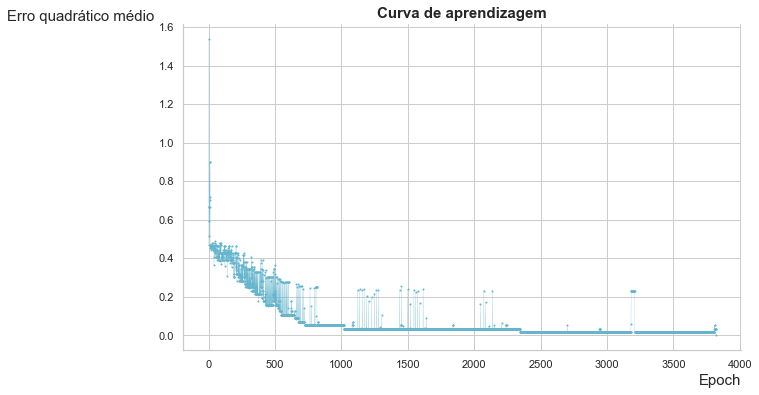

In [72]:
# Plotando a curva de aprendizagem:
plt.figure(figsize = (10, 6))
plt.title('Curva de aprendizagem', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, loc='right')
plt.ylabel('Erro quadrático médio', rotation=0, fontsize=15, loc='top')
plt.plot(lista_epochs_n, lista_theta_θ, linewidth=0.2, marker='o', markersize=1, color='c')

A aproximação do erro quadrático médio de seu mínimo indica uma melhora na convergência do processo de adaptação da rede neural. Portanto, considerando que o gráfico é finalizado antes das 5000 epochs (nmax), temos que θ (gradiente do erro médio quadrático) consegue alcançar um valor menor que 0.01, atingindo, portanto, o critério de parada.

Por fim, devemos verificar também quais foram os valores estimados para os pesos e bias de cada neurônio da camada escondida e da camada de saída. Veja:

In [74]:
# Consertando as dimensões das listas:
Bh_final = np.squeeze(Bh_final)
Bs_final = np.squeeze(Bs_final)

# Separando os pesos e bias finais para o neurônio escondido 1:
final_w1_hidden1 = Wh_final[0][0]
final_w2_hidden1 = Wh_final[1][0]
final_w3_hidden1 = Wh_final[2][0]
final_w4_hidden1 = Wh_final[3][0]
final_b_hidden1 = Bh_final[0]
print('O valor ótimo de w1 encontrado para o neurônio oculto 1 é:', final_w1_hidden1)
print('O valor ótimo de w2 encontrado para o neurônio oculto 1 é:', final_w2_hidden1)
print('O valor ótimo de w3 encontrado para o neurônio oculto 1 é:', final_w3_hidden1)
print('O valor ótimo de w4 encontrado para o neurônio oculto 1 é:', final_w4_hidden1)
print('O valor ótimo de b encontrado para o neurônio oculto 1 é:', final_b_hidden1)
# Separando os pesos e bias finais para o neurônio escondido 2:
final_w1_hidden2 = Wh_final[0][1]
final_w2_hidden2 = Wh_final[1][1]
final_w3_hidden2 = Wh_final[2][1]
final_w4_hidden2 = Wh_final[3][1]
final_b_hidden2 = Bh_final[1]
print('\nO valor ótimo de w1 encontrado para o neurônio oculto 2 é:', final_w1_hidden2)
print('O valor ótimo de w2 encontrado para o neurônio oculto 2 é:', final_w2_hidden2)
print('O valor ótimo de w3 encontrado para o neurônio oculto 2 é:', final_w3_hidden2)
print('O valor ótimo de w4 encontrado para o neurônio oculto 2 é:', final_w4_hidden2)
print('O valor ótimo de b encontrado para o neurônio oculto 2 é:', final_b_hidden2)

# Separando os pesos e bias finais para o neurônio de saída 1:
final_w1_output1 = Ws_final[0][0]
final_w2_output1 = Ws_final[1][0]
final_b_output1 = Bs_final[0]
print('\nO valor ótimo de w1 encontrado para o neurônio de saída 1 é:', final_w1_output1)
print('O valor ótimo de w2 encontrado para o neurônio de saída 1 é:', final_w2_output1)
print('O valor ótimo de b encontrado para o neurônio de saída 1 é:', final_b_output1)
# Separando os pesos e bias finais para o neurônio de saída 2:
final_w1_output2 = Ws_final[0][1]
final_w2_output2 = Ws_final[1][1]
final_b_output2 = Bs_final[1]
print('\nO valor ótimo de w1 encontrado para o neurônio de saída 2 é:', final_w1_output2)
print('O valor ótimo de w2 encontrado para o neurônio de saída 2 é:', final_w2_output2)
print('O valor ótimo de b encontrado para o neurônio de saída 2 é:', final_b_output2)
# Separando os pesos e bias finais para o neurônio de saída 3:
final_w1_output3 = Ws_final[0][2]
final_w2_output3 = Ws_final[1][2]
final_b_output3 = Bs_final[2]
print('\nO valor ótimo de w1 encontrado para o neurônio de saída 3 é:', final_w1_output3)
print('O valor ótimo de w2 encontrado para o neurônio de saída 3 é:', final_w2_output3)
print('O valor ótimo de b encontrado para o neurônio de saída 3 é:', final_b_output3)

O valor ótimo de w1 encontrado para o neurônio oculto 1 é: 355862399.897405
O valor ótimo de w2 encontrado para o neurônio oculto 1 é: 1087275134.6304982
O valor ótimo de w3 encontrado para o neurônio oculto 1 é: -2113735065.0561628
O valor ótimo de w4 encontrado para o neurônio oculto 1 é: -929791033.304947
O valor ótimo de b encontrado para o neurônio oculto 1 é: 392849049.9853305

O valor ótimo de w1 encontrado para o neurônio oculto 2 é: 163297290.82327986
O valor ótimo de w2 encontrado para o neurônio oculto 2 é: 171483464.01939252
O valor ótimo de w3 encontrado para o neurônio oculto 2 é: -1530951822.1336749
O valor ótimo de w4 encontrado para o neurônio oculto 2 é: -632584222.8102869
O valor ótimo de b encontrado para o neurônio oculto 2 é: 1399632196.939072

O valor ótimo de w1 encontrado para o neurônio de saída 1 é: 3258.6237192557696
O valor ótimo de w2 encontrado para o neurônio de saída 1 é: 1358.016134090603
O valor ótimo de b encontrado para o neurônio de saída 1 é: 1288

### Parte III: classificação dos dados de teste

Através do treinamento da rede, desvendamos o número de neurônios escondidos que melhor resolve o problema e os valores das matrizes de pesos de cada camada. Agora, portanto, somos capazes de classificar os dados do conjunto de teste pelo uso da função "predicao". Observe:

In [75]:
# TREINO
# Dados do problema:
inputs = np.array(l_inputs_teste)    # Espaço de entrada do problema.
Wh = Wh_final    # Matriz de pesos da camada escondida.
Bh = Bh_final    # Matriz de bias da camada escondida.
Ws = Ws_final    # Matriz de pesos da camada de saída.
Bs = Bs_final    # Matriz de bias da camada de saída.

# Chamando a função "predicao":
output_predito = predicao(inputs, Wh, Bh, Ws, Bs)

Os valores preditos para o output são:

In [76]:
print("Outputs dos dados de teste: \n", output_predito)

Outputs dos dados de teste: 
 [[-1.  1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]
 [ 1. -1. -1.]
 [ 1. -1. -1.]
 [ 1. -1. -1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]
 [ 1. -1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]
 [ 1. -1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1. -1.  1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1.  1. -1.]
 [-1. -1.  1.]]
